In [1]:
import numpy as np
from numpy import sin, cos,exp,pi
from time import process_time, time
from scipy.optimize import curve_fit, least_squares
from scipy.fft import fft,fftshift,fft2, fftfreq, ifft
from scipy.signal import oaconvolve, medfilt2d

from scipy.ndimage import rotate
from scipy.interpolate import interp1d

# import h5py
from skimage.transform import radon
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import transforms
from PIL import Image, ImageFilter
import joblib as jb
import tifffile as tfl
import os
from IPython.display import clear_output
import re
import pandas as pd

from astropy.io import fits

In [2]:
%run "C:\Users\gabri\Documents\Python Scripts\NPGMI-Library\NPGMI Base Code.ipynb"

In [3]:

# measured = pd.read_excel("NG6_Spectrum_FinalCorrections.xlsx").to_numpy().T
# measured[0]*=1e-9
# calculated = pd.read_excel("ng6_MCNP_spectrum.xlsx").to_numpy().T
# calculated[0]*=1e-9
# k_maxwell40 = maxwell_k(40,1.675e-27,len(measured[0]))
# k_maxwell5A = maxwell_k(19.52,1.675e-27,len(measured[0]))

# norm = 1.05457e-34/1.675e-27 # h-bar over neutron mass 


In [15]:
def maxwell_k(Tc,mass, N_points):
    a = np.sqrt(1.38e-23*Tc/(mass))
    v_dist = maxwell(scale = a)
    q_mass = 1.05457e-34/mass
    k_vals = np.linspace(v_dist.ppf(0.1),v_dist.ppf(0.999),N_points) / q_mass
    return np.asarray([k_vals, np.sqrt(2/pi)*q_mass*q_mass/(a*a*a)*k_vals*k_vals*np.exp(-k_vals*k_vals*q_mass*q_mass/(2*a*a))])

def maxk_raw(k,Tc):
    a = np.sqrt(1.38e-23*Tc/(1.675e-27))
    q_mass = 1.05457e-34/1.675e-27
    return np.sqrt(2/pi)*q_mass*q_mass/(a*a*a)*k*k*np.exp(-k*k*q_mass*q_mass/(2*a*a))
    

### LANL Experiment Data 

In [4]:


h = 16e-6
L = 425.345e-2
L1 =  212.52e-2
p = 3e-6

pxl_to_m = 50e-6





(512, 512)


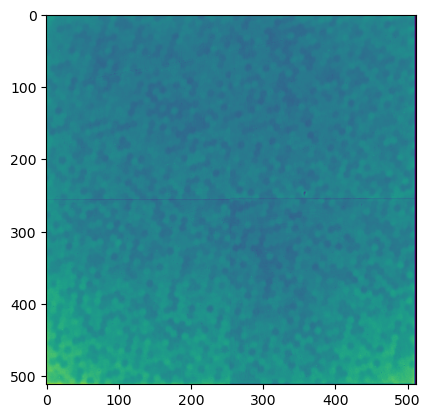

In [5]:
normed = tfl.imread(r"C:\Users\gabri\Documents\Python Scripts\LANL Experiment\detector_norm_sum.tiff")
normed = np.append(normed,np.zeros((512,2)),axis = -1)
print(normed.shape)
plt.imshow(normed)
plt.show()

(72,)


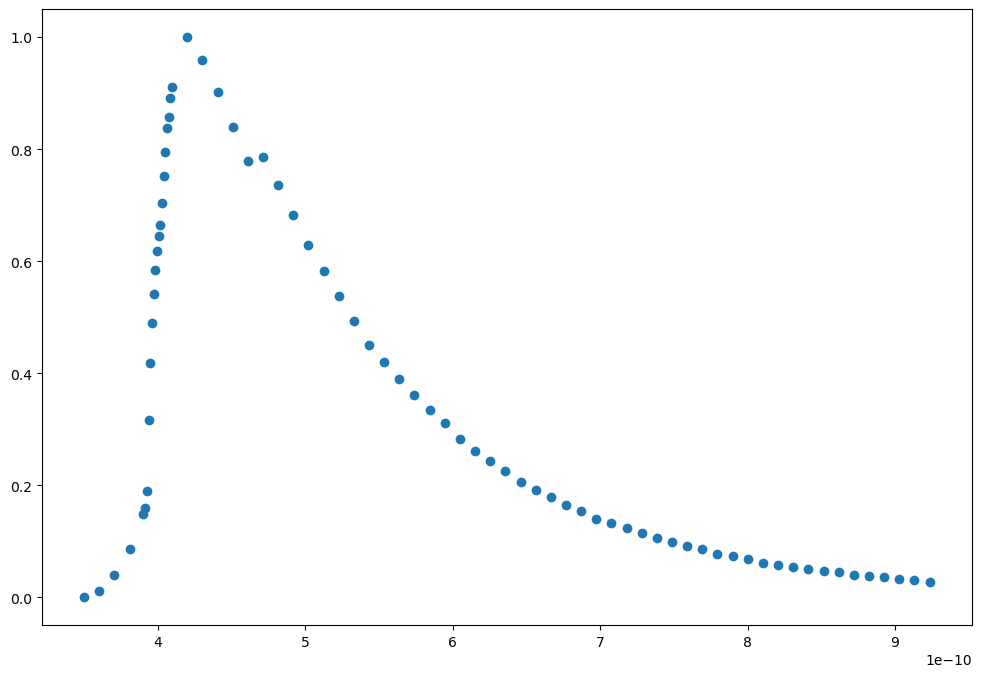

In [204]:
oam4basepath = r"C:\Users\gabri\Documents\Python Scripts\LANL Experiment\OAM4D00"
oam7basepath = r"C:\Users\gabri\Documents\Python Scripts\LANL Experiment\OAM7D"


spec_data = np.genfromtxt("LANL lam dist.csv", delimiter=",", skip_header = 1)[:,-2:]

reset_cutoff = (np.argmin(np.abs(spec_data[:,0]-3.5)),2210)

spec_data = spec_data[reset_cutoff[0]:reset_cutoff[1]]

pairs = [spec_data[0]]

for ind, pair in enumerate(spec_data[1:]):
    if np.abs(pair[0] - pairs[-1][0]) > 0.1 or (np.abs(pair[0] - pairs[-1][0]) > 0.01 and (3.9 < pair[0] < 4.1)):
        pairs.append(pair)
    
lam, plam = np.array(pairs).T
print(lam.shape)
lam *= 1e-10
plam = (plam - np.min(plam))/(np.max(plam) - np.min(plam))


fig,ax1 = plt.subplots(figsize = (12,8))

ax1.plot(lam,plam, "o")



lamlocs = np.argmin(np.abs(spec_data[:,0][:,None] - lam[None,:]*1e10), axis = 0)



plt.show()
plt.close(fig)

In [205]:
all_oam4_imgs_partsummed = [Image.fromarray(np.sum([fits.open((oam4basepath + "%d" + "\\datafiles\\" + "oam4D00%d_0"\
                            + "0"*(4-len(str(i))) + "%d.fits") % (d,d,i))[0].data - normed for i in range(reset_cutoff[0],reset_cutoff[1])], axis = 0)) for d in range(5)]

In [206]:
all_oam7_imgs_partsummed = [Image.fromarray(np.sum([fits.open((oam7basepath + "0"*(3 - len(str(d))) + "%d\\datafiles\\" + "Dscan_" + "0"*(3 - len(str(d)))+ "%d_0"\
                            + "0"*(4-len(str(i))) + "%d.fits") % (d,d,i))[0].data - normed for i in range(reset_cutoff[0],reset_cutoff[1])], axis = 0)) for d in range(13)]

### Alignment

In [207]:
oam4rotdegs = [3,3,2,2,2]

all_oam4_imgs_partsummed_rotated = [img.copy().rotate(oam4rotdegs[i]) for i, img in enumerate(all_oam4_imgs_partsummed)]
img = all_oam4_imgs_partsummed_rotated[2]


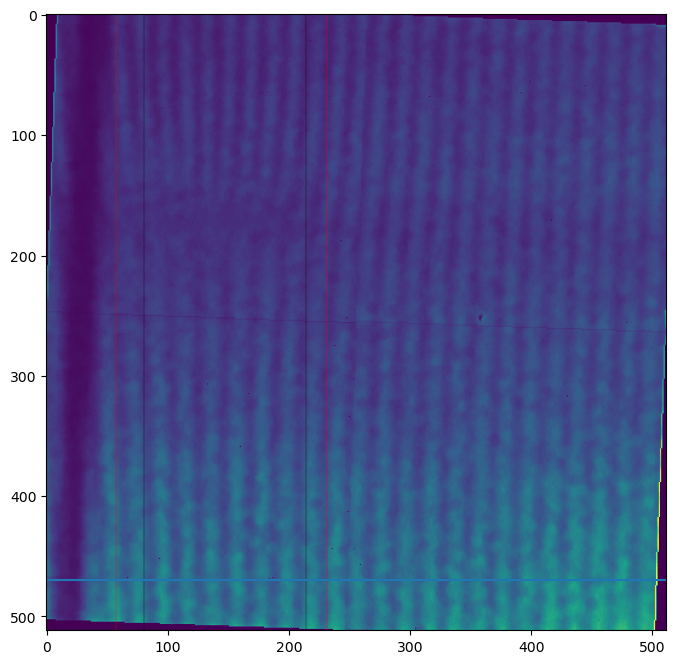

In [210]:
fig, ax = plt.subplots(figsize = (8,8))
ax.imshow(np.array(img).T, aspect = "auto", clim = (0,5e3))

# ax.axvline(132, color = "yellow", lw = 0.25)

ax.axvline(57, color = "red", lw = 0.25)
ax.axvline(231, color = "red", lw = 0.25)
ax.axvline(80, color = "black", lw = 0.25)
ax.axvline(214, color = "black", lw = 0.25)

oam4forkranges = [(67,317), (70,315), (70,267), (59,243), (57,231)]
oam4noforkranges = [(124,295), (110,290),(105,250), (85,224), (80,214)]
ax.axhline(470)

plt.show()
# fig.savefig("tiltedfork.jpg")
plt.close(fig)

In [211]:
oam7rotdegs = [3.75,4,4.25,2.5,2,3.25,2.75,2.5,2.25,2,2.25,2.25,1]

all_oam7_imgs_partsummed_rotated = [img.copy().rotate(oam7rotdegs[i]) for i, img in enumerate(all_oam7_imgs_partsummed)]
img = all_oam7_imgs_partsummed_rotated[2]


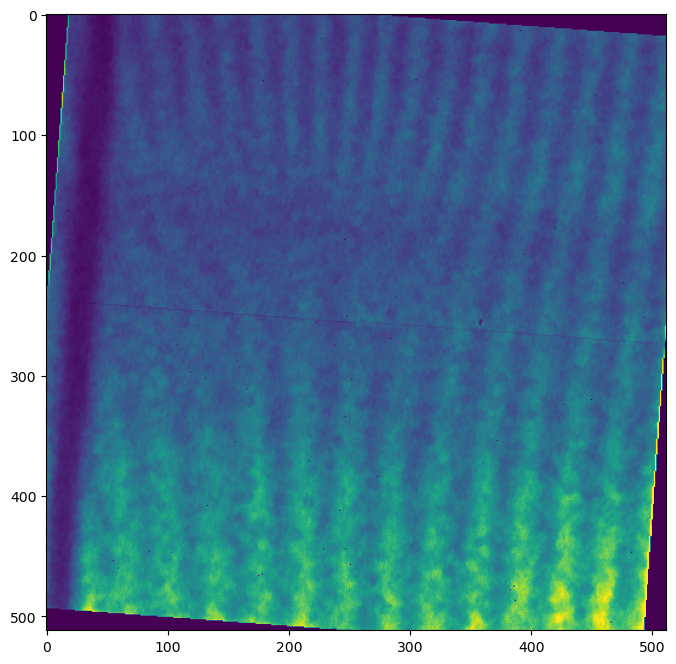

In [212]:
fig, ax = plt.subplots(figsize = (8,8))
ax.imshow(np.array(img).T, aspect = "auto", clim = (0,9e2))


# ax.axvline(210, color = "purple", lw = 0.5)


# ax.axvline(76, color = "red", lw = 0.25)
# ax.axvline(406, color = "red", lw = 0.25)
# ax.axvline(159, color = "black", lw = 0.25)
# ax.axvline(340, color = "black", lw = 0.25)


oam7forkranges = [(96,396), (72,404), (74,406), (77,402), (76,402), (78,404), (66,407), (65,405), (63,403), (67,401),(67,401),(66,401),(55,293)]
oam7noforkranges = [(188,330), (155,336),(159,340), (143,354), (139,353), (136,348), (110,362), (110,361), (110,363), (107,367),(105,367),(105,365),(83,248)]


plt.show()
# fig.savefig("tiltedfork.jpg")
plt.close(fig)

In [213]:
    
all_oam4_fork_subregion = [np.array(img)[oam4forkranges[i][0]:oam4forkranges[i][1],10:90] for i, img in enumerate(all_oam4_imgs_partsummed_rotated)]
all_oam4_nofork_subregion = [np.array(img)[oam4noforkranges[i][0]:oam4noforkranges[i][1],270:480] for i, img in enumerate(all_oam4_imgs_partsummed_rotated)]

all_oam4_fork_intens = [np.sum(sub, axis = -1) for sub in all_oam4_fork_subregion]
all_oam4_nofork_intens = [np.sum(sub, axis = -1) for sub in all_oam4_nofork_subregion]


In [214]:
all_oam7_fork_subregion = [np.array(img)[oam7forkranges[i][0]:oam7forkranges[i][1],10:90] for i, img in enumerate(all_oam7_imgs_partsummed_rotated)]
all_oam7_nofork_subregion = [np.array(img)[oam7noforkranges[i][0]:oam7noforkranges[i][1],270:480] for i, img in enumerate(all_oam7_imgs_partsummed_rotated)]

all_oam7_fork_intens = [np.sum(sub, axis = -1) for sub in all_oam7_fork_subregion]
all_oam7_nofork_intens = [np.sum(sub, axis = -1) for sub in all_oam7_nofork_subregion]


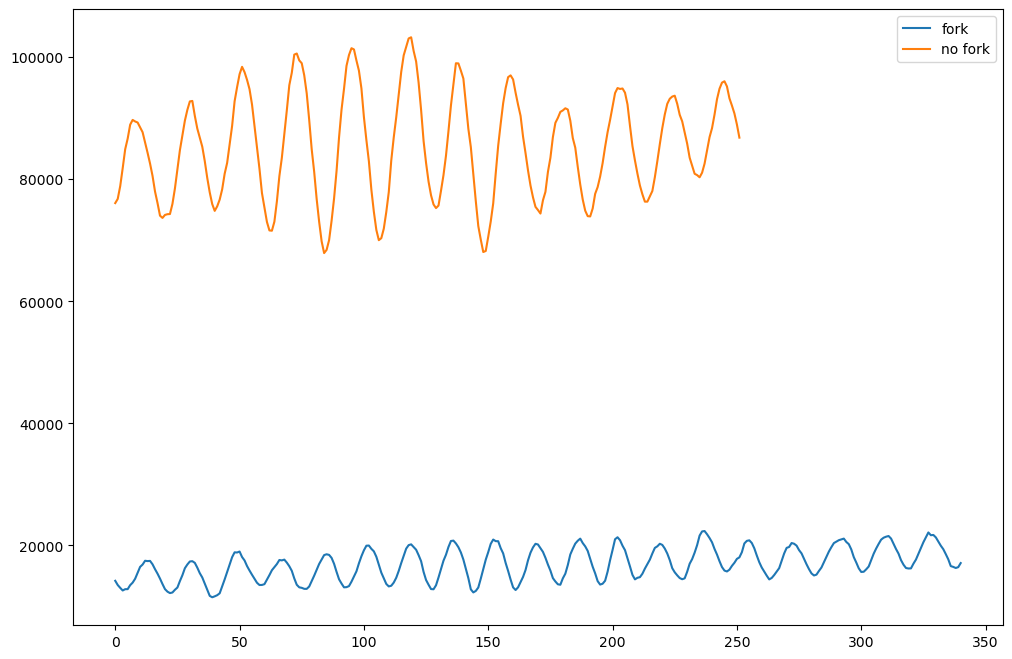

In [215]:
fig, ax1 = plt.subplots(figsize = (12,8))
ax1.plot(all_oam7_fork_intens[6], label = "fork")
ax1.plot(all_oam7_nofork_intens[6], label = "no fork")
ax1.legend()
plt.show()
plt.close(fig)

In [411]:
p**2 / 7.5e-10

0.012000000000000002

### Contrast Fitting

In [216]:
d_oam4 = np.arange(7.5,17.5 + 2.5,2.5)*1e-3


oam4_fork_fitparams = np.array([best_fit_moire_period(cosine_func, np.linspace(0,len(intens),len(intens))*pxl_to_m,\
                intens, p, L, d_oam4[i]) for i, intens in enumerate(all_oam4_fork_intens)])

oam4_nofork_fitparams = np.array([best_fit_moire_period(cosine_func, np.linspace(0,len(intens),len(intens))*pxl_to_m,\
                intens, p, L, d_oam4[i]) for i, intens in enumerate(all_oam4_nofork_intens)])

In [217]:
d_oam7 = np.repeat(d_oam4,3)[:-2] + 1e-3
oam7_fork_fitparams = np.array([best_fit_moire_period(cosine_func, np.linspace(0,len(intens),len(intens))*pxl_to_m,\
                intens, p, L, d_oam7[i]) for i, intens in enumerate(all_oam7_fork_intens)])

oam7_nofork_fitparams = np.array([best_fit_moire_period(cosine_func, np.linspace(0,len(intens),len(intens))*pxl_to_m,\
                intens, p, L, d_oam7[i]) for i, intens in enumerate(all_oam7_nofork_intens)])

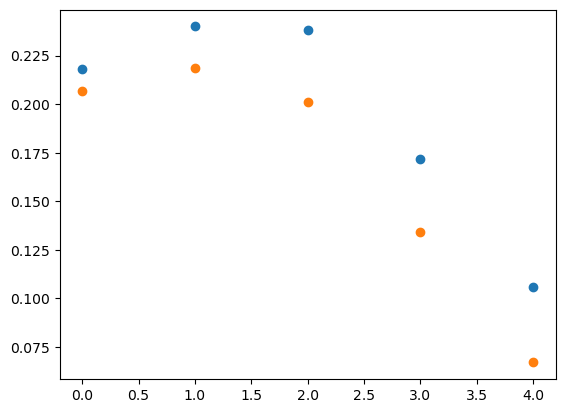

In [218]:
plt.plot(np.abs(oam4_fork_fitparams[...,1]/oam4_fork_fitparams[...,0]), "o")
plt.plot(np.abs(oam4_nofork_fitparams[...,1]/oam4_nofork_fitparams[...,0]), "o")
plt.show()

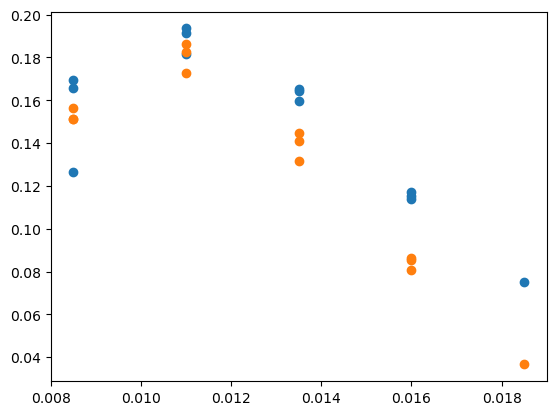

In [219]:
plt.plot(d_oam7,np.abs(oam7_fork_fitparams[...,1]/oam7_fork_fitparams[...,0]), "o")
plt.plot(d_oam7,np.abs(oam7_nofork_fitparams[...,1]/oam7_nofork_fitparams[...,0]), "o")
plt.show()

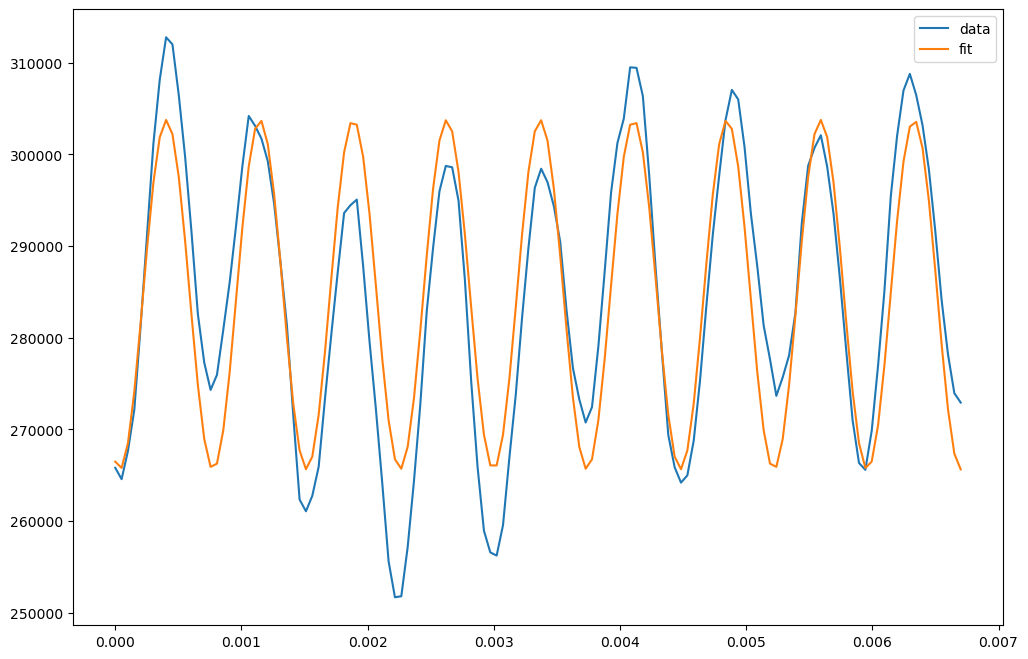

In [196]:
fig, ax1 = plt.subplots(figsize = (12,8))
ind = 4
# intens = all_oam4_fork_intens[ind]

# x = np.linspace(0,len(intens),len(intens))*pxl_to_m
# ax1.plot(x,intens, label = "data")
# ax1.plot(x, cosine_func(x,*oam4_fork_fitparams[ind]), label = "fit")
intens = all_oam4_nofork_intens[ind]

x = np.linspace(0,len(intens),len(intens))*pxl_to_m
ax1.plot(x,intens, label = "data")
ax1.plot(x, cosine_func(x,*oam4_nofork_fitparams[ind]), label = "fit")

ax1.legend()
plt.show()
plt.close(fig)

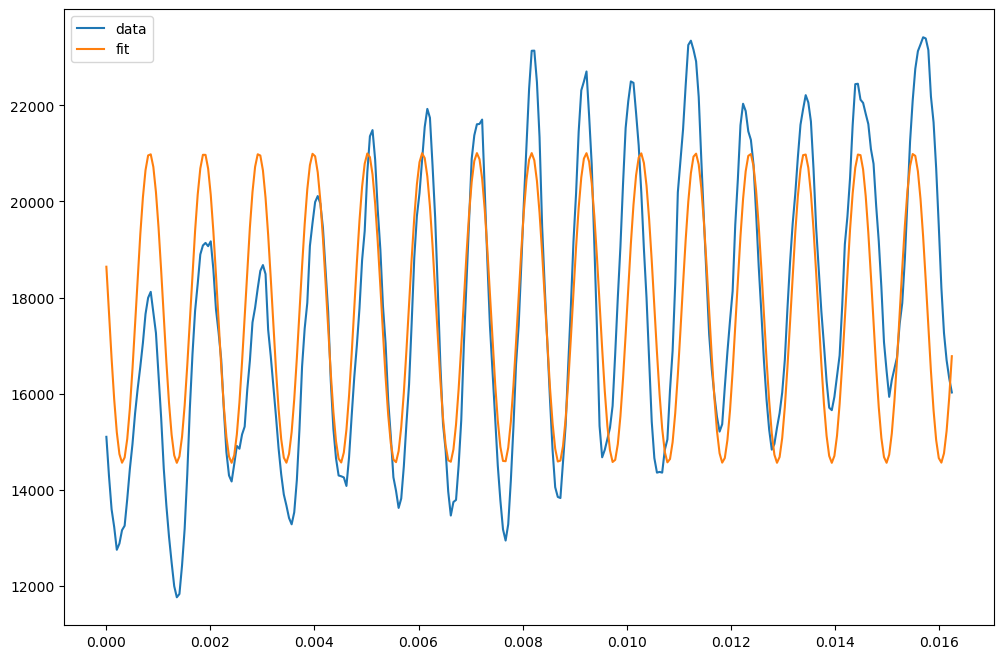

In [199]:
fig, ax1 = plt.subplots(figsize = (12,8))

ind = 2
intens = all_oam7_fork_intens[ind]

x = np.linspace(0,len(intens),len(intens))*pxl_to_m
ax1.plot(x,intens, label = "data")
ax1.plot(x, cosine_func(x,*oam7_fork_fitparams[ind]), label = "fit")

intens = all_oam7_nofork_intens[ind]

# x = np.linspace(0,len(intens),len(intens))*pxl_to_m
# ax1.plot(x,intens, label = "data")
# ax1.plot(x, cosine_func(x,*oam7_nofork_fitparams[ind]), label = "fit")

ax1.legend()
plt.show()
plt.close(fig)

### Contrast Density Plot

In [272]:
plam_sum = np.sum(spec_data[:,1])

bin_height = 0.05 * plam_sum
bindices = [0]
running_sum = 0


for i, plam in enumerate(spec_data[:,1]):
    if running_sum > bin_height:
        bindices.append(i)
        running_sum = 0
    running_sum += plam
    
bindices.append(len(spec_data[:,1]))
bindices = np.repeat(bindices,2)[1:-1].reshape(len(bindices*2)//2 - 1,2) + reset_cutoff[0]

In [278]:
lam_oam4_imgs = []

for start, stop in bindices:
    lam_oam4_imgs.append([])
    for d in range(len(d_oam4)):
        
        lam_oam4_imgs[-1].append(Image.fromarray(np.sum([fits.open((oam4basepath + "%d" + "\\datafiles\\" + "oam4D00%d_0"\
        + "0"*(4-len(str(i))) + "%d.fits") % (d,d,i))[0].data - normed for i in range(start,stop)],\
        axis = 0)).rotate(oam4rotdegs[d]))


In [280]:
lam_oam7_imgs = []

for start, stop in bindices:
    lam_oam7_imgs.append([])
    for d in range(len(d_oam7)):
        lam_oam7_imgs[-1].append(Image.fromarray(np.sum([fits.open((oam7basepath + "0"*(3 - len(str(d))) + "%d\\datafiles\\" + "Dscan_" + "0"*(3 - len(str(d)))+ "%d_0"\
        + "0"*(4-len(str(i))) + "%d.fits") % (d,d,i))[0].data - normed for i in range(start,stop)],\
        axis = 0)).rotate(oam7rotdegs[d]))

In [281]:
lam_oam4_fork_subregion = [[np.array(img)[oam4forkranges[d][0]:oam4forkranges[d][1],10:90] for d, img in enumerate(img_list)] for img_list in lam_oam4_imgs]
lam_oam4_nofork_subregion = [[np.array(img)[oam4noforkranges[d][0]:oam4noforkranges[d][1],270:480] for d, img in enumerate(img_list)] for img_list in lam_oam4_imgs]

lam_oam4_fork_intens = [[np.sum(sub, axis = -1) for sub in sub_list] for sub_list in lam_oam4_fork_subregion]
lam_oam4_nofork_intens = [[np.sum(sub, axis = -1) for sub in sub_list] for sub_list in lam_oam4_nofork_subregion]

In [285]:
lam_oam7_fork_subregion = [[np.array(img)[oam7forkranges[d][0]:oam7forkranges[d][1],10:90] for d, img in enumerate(img_list)] for img_list in lam_oam7_imgs]
lam_oam7_nofork_subregion = [[np.array(img)[oam7noforkranges[d][0]:oam7noforkranges[d][1],270:480] for d, img in enumerate(img_list)] for img_list in lam_oam7_imgs]

lam_oam7_fork_intens = [[np.sum(sub, axis = -1) for sub in sub_list] for sub_list in lam_oam7_fork_subregion]
lam_oam7_nofork_intens = [[np.sum(sub, axis = -1) for sub in sub_list] for sub_list in lam_oam7_nofork_subregion]

In [291]:
lam_oam4_fork_fitparams = np.array([[best_fit_moire_period(cosine_func, np.linspace(0,len(intens),len(intens))*pxl_to_m,\
                intens, p, L, d_oam4[i]) for i, intens in enumerate(intens_list)] for intens_list in lam_oam4_fork_intens])

lam_oam4_nofork_fitparams = np.array([[best_fit_moire_period(cosine_func, np.linspace(0,len(intens),len(intens))*pxl_to_m,\
                intens, p, L, d_oam4[i]) for i, intens in enumerate(intens_list)] for intens_list in lam_oam4_nofork_intens])

In [293]:
lam_oam7_fork_fitparams = np.array([[best_fit_moire_period(cosine_func, np.linspace(0,len(intens),len(intens))*pxl_to_m,\
                intens, p, L, d_oam7[i]) for i, intens in enumerate(intens_list)] for intens_list in lam_oam7_fork_intens])

lam_oam7_nofork_fitparams = np.array([[best_fit_moire_period(cosine_func, np.linspace(0,len(intens),len(intens))*pxl_to_m,\
                intens, p, L, d_oam7[i]) for i, intens in enumerate(intens_list)] for intens_list in lam_oam7_nofork_intens])

In [400]:
cont_oam4 = {"fork": np.abs(lam_oam4_fork_fitparams[...,1]/lam_oam4_fork_fitparams[...,0]), "nofork": np.abs(lam_oam4_nofork_fitparams[...,1]/lam_oam4_nofork_fitparams[...,0])}

cont_oam7 = {"fork": np.abs(lam_oam7_fork_fitparams[...,1]/lam_oam7_fork_fitparams[...,0]), "nofork": np.abs(lam_oam7_nofork_fitparams[...,1]/lam_oam7_nofork_fitparams[...,0])}

cont_oam7["fork"] = np.array([np.mean(cont_oam7["fork"][:,i:i+3], axis = -1) for i in range(cont_oam7["fork"].shape[-1] - 1)[::3]] + [cont_oam7["fork"][:,-1]]).T
cont_oam7["nofork"] = np.array([np.mean(cont_oam7["nofork"][:,i:i+3], axis = -1) for i in range(cont_oam7["nofork"].shape[-1] - 1)[::3]] + [cont_oam7["nofork"][:,-1]]).T


In [407]:
lam_labels = ["(%.1f-%.1f)" % (spec_data[start,0],spec_data[stop-1,0]) for start,stop in (bindices - reset_cutoff[0])] 
d_oam4_labels = ["%.1f" % (d*1e3) for d in d_oam4]

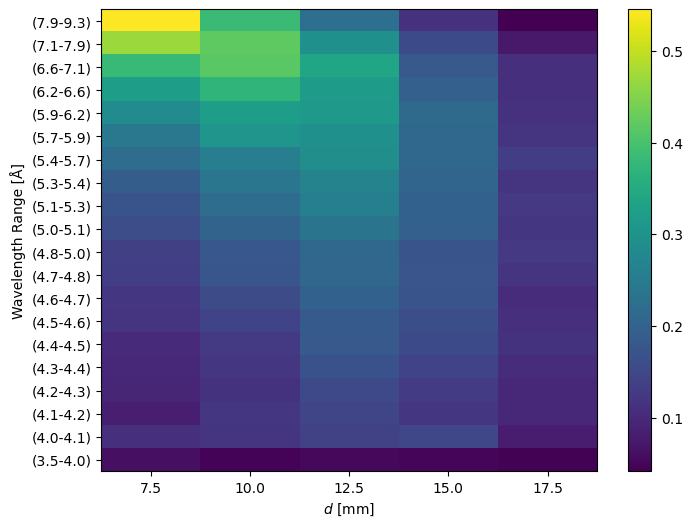

In [406]:
fig, ax = plt.subplots(figsize = (8,6))
c = ax.imshow(cont_oam4["fork"], aspect = "auto", origin = "lower")


ax.set_xticks(range(len(d_labels)))
ax.set_xticklabels(d_labels)

ax.set_yticks(range(len(lam_labels)))
ax.set_yticklabels(lam_labels)

ax.set_xlabel(r"$d$ [mm]")
ax.set_ylabel("Wavelength Range [Å]")
fig.colorbar(c)

plt.show()
plt.close(fig)

In [408]:
d_oam7_labels = ["%.1f" % (d*1e3) for d in np.unique(d_oam7)]

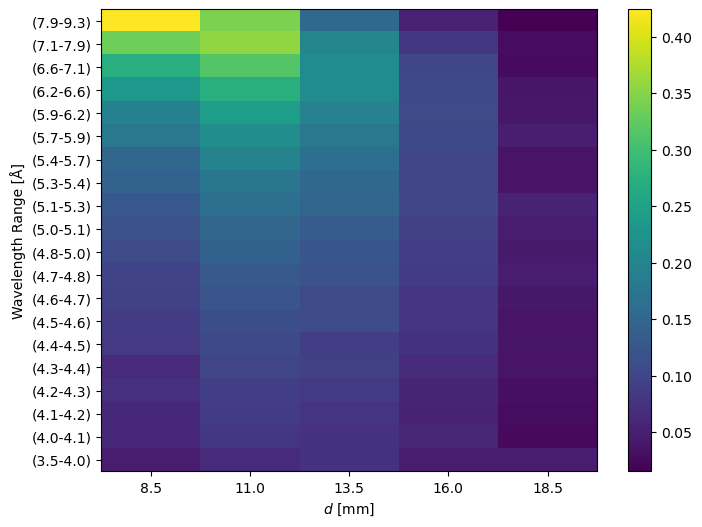

In [409]:
fig, ax = plt.subplots(figsize = (8,6))
c = ax.imshow(cont_oam7["nofork"], aspect = "auto", origin = "lower")


ax.set_xticks(range(len(d_oam7_labels)))
ax.set_xticklabels(d_oam7_labels)

ax.set_yticks(range(len(lam_labels)))
ax.set_yticklabels(lam_labels)

ax.set_xlabel(r"$d$ [mm]")
ax.set_ylabel("Wavelength Range [Å]")
fig.colorbar(c)

plt.show()
plt.close(fig)

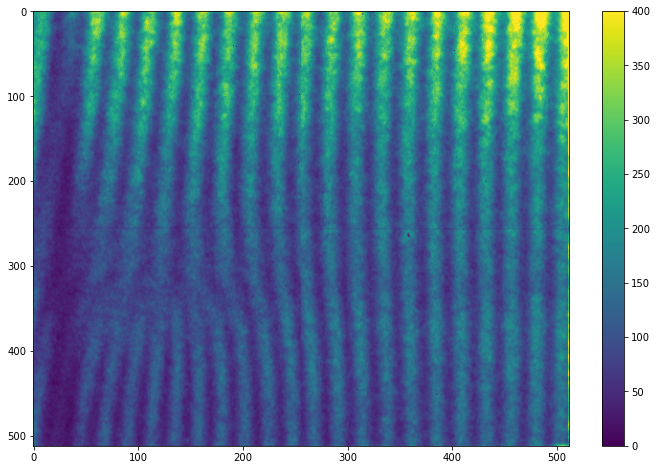

In [458]:
fig1,ax1 = plt.subplots(figsize = (12,8))
upc = 400
c = ax1.imshow(np.rot90(lamdata[0][6]), aspect = "auto", clim = (0,upc))
fig1.colorbar(c)
fig1.savefig("oam4fork.jpg")
plt.show()

In [583]:
excelfile = pd.ExcelFile("200cntopensummary.xls")
excelallphase = pd.read_excel(excelfile, skiprows = np.arange(25,649),usecols = np.arange(16,26))
sgpstrings = ["0300","0400","0500","0600","0700","0800","0900","1000","2000",]
# sgpstrings = ["0300"]

excelcont = np.array([(pd.read_excel(excelfile, "p%s" % sgp, usecols = (2,7) ))  for sgp in sgpstrings]).swapaxes(1,2)
# changelam = excelcont.swapaxes(1,2).swapaxes(0,2)[0].T[3:-1] + np.array([0.8,1.1,1.4,1.75,1.8])[:,None]


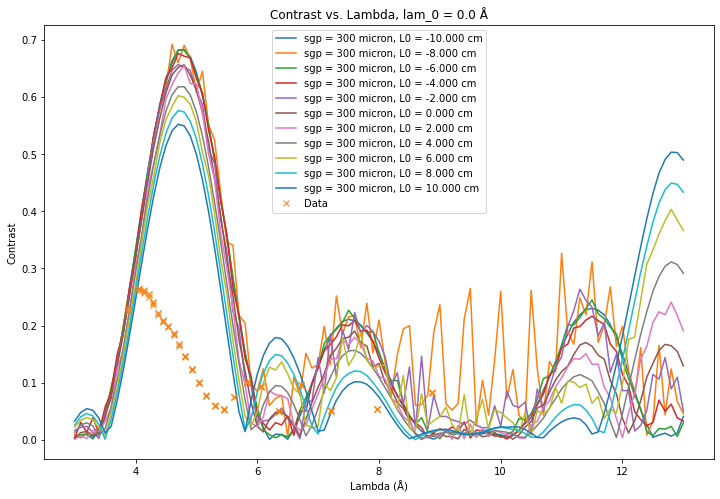

In [596]:
fig1, ax1 = plt.subplots(figsize = (12,8))
lam_0 = 0
for i in range(simLANL.shape[0])[:]:
    ax1.plot(testsd["lam"]*1e10-lam_0,simLANL[i], label = "sgp = %.f micron, L0 = %.3f cm" % (sgptest*1e6, L0LANL[i]*1e2))

ax1.plot(excelcont[0][0],excelcont[0][1],"x", label = "Data")
ax1.set_xlabel("Lambda (Å)")
ax1.set_ylabel("Contrast")
ax1.set_title("Contrast vs. Lambda, lam_0 = %.1f Å" % lam_0)
ax1.legend()
fig1.savefig("L1shiftsgp300.jpg")
plt.show()

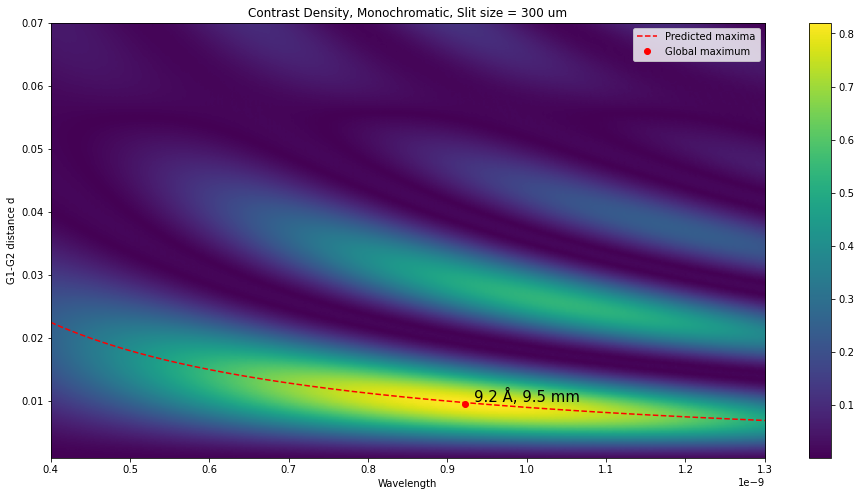

In [137]:
fig, ax1 = plt.subplots(figsize = (16,8))
maxpoint3 = (LANLlams[global_max(LANLcont3)[1]],LANLd[global_max(LANLcont3)[0]])
c = ax1.imshow(LANLcont3, aspect = "auto", extent = [LANLlams[0],LANLlams[-1],LANLd[0],LANLd[-1]], origin = "lower")
fig.colorbar(c)
expected_curve3 = expected_peaks(LANL3sd)
ax1.plot(LANLlams[expected_curve3<LANLd[-1]],expected_curve3[expected_curve3<LANLd[-1]],"--", color = "red",label = "Predicted maxima")

ax1.plot(*maxpoint3, "ro", label = "Global maximum")
ax1.annotate("%.1f Å, %.1f mm" % (maxpoint3[0]*1e10,maxpoint3[1]*1e3), maxpoint3, xytext = (maxpoint3[0]*1e10,maxpoint3[1]*1e3 * 0.3) ,textcoords = "offset points", color = "black", fontsize = 15)

ax1.set_xlabel("Wavelength")
ax1.set_ylabel("G1-G2 distance d")
ax1.set_title("Contrast Density, Monochromatic, Slit size = %2.f um" % (LANL3sd["slit"]*1e6))
ax1.legend(loc="best")
# fig.savefig("SlitSize300umDensity.jpg")
plt.show()

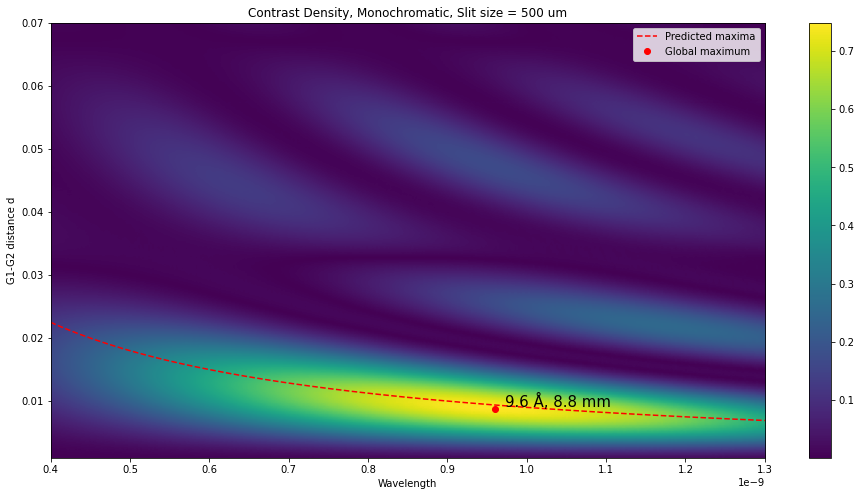

In [138]:
fig, ax1 = plt.subplots(figsize = (16,8))
maxpoint5 = (LANLlams[global_max(LANLcont5)[1]],LANLd[global_max(LANLcont5)[0]])
c = ax1.imshow(LANLcont5, aspect = "auto", extent = [LANLlams[0],LANLlams[-1],LANLd[0],LANLd[-1]], origin = "lower")
fig.colorbar(c)
expected_curve5 = expected_peaks(LANL5sd)
ax1.plot(LANLlams[expected_curve5<LANLd[-1]],expected_curve5[expected_curve5<LANLd[-1]],"--", color = "red",label = "Predicted maxima")

ax1.plot(*maxpoint5, "ro", label = "Global maximum")
ax1.annotate("%.1f Å, %.1f mm" % (maxpoint5[0]*1e10,maxpoint5[1]*1e3), maxpoint5, xytext = (maxpoint5[0]*1e10,maxpoint5[1]*1e3 * 0.3) ,textcoords = "offset points", color = "black", fontsize = 15)

ax1.set_xlabel("Wavelength")
ax1.set_ylabel("G1-G2 distance d")
ax1.set_title("Contrast Density, Monochromatic, Slit size = %2.f um" % (LANL5sd["slit"]*1e6))
ax1.legend(loc="best")
# fig.savefig("SlitSize500umDensity.jpg")
plt.show()

### PSI Broken Monochromator

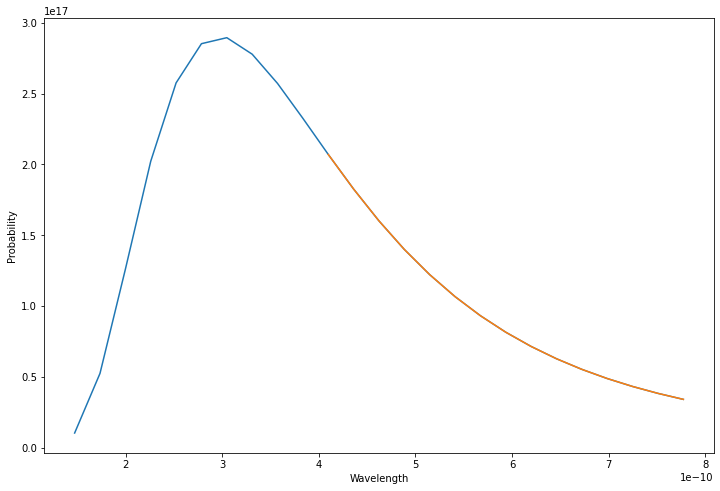

In [16]:
# Tm = (6.626e-34**2)/(2*1.38e-23*1.675e-27*(0.3e-9**2))
Tm = 53.8
print(Tm)

maxwell3 = maxwell_k(Tm,1.675e-27,25)

lams3 = np.linspace(2*pi/maxwell3[0][0],2*pi/maxwell3[0][-1], len(maxwell3[0]))
lams4 = lams3[:np.where(lams3 < 4e-10)[0][0]]
km3 = 2*pi/lams3
km4 = 2*pi/lams4

plam3 = maxk_raw(km3,Tm)*km3**2
plam4 = maxk_raw(km4,Tm)*km4**2


fig, ax1 = plt.subplots(figsize = (12,8))
ax1.plot(lams3,plam3)

ax1.plot(lams4,plam4)
ax1.set_xlabel("Wavelength")
ax1.set_ylabel("Probability")
plt.show()
# print(lams3[np.argmax(plam3)]*5e28*4.149e-15*8.53e-6)

In [13]:

dPSI = np.linspace(4,10,4)*1e-3
PSIsd3L5 = {"lam":lams3,"plam":plam3,"L":5,"L1":5/2,"mt":5,"th_n":0,"th_m":0,"p":3e-6,"h":8.53e-6,"slit":750e-6,\
          "res":50e-6,"d":dPSI,"d0":0.0e-3,"xbin":2.37e-6,"camsize":8.5e-2,"N_moire":20, "convmode":"same"}
PSIsd4L5 = {"lam":lams4,"plam":plam4,"L":5,"L1":5/2,"mt":5,"th_n":0,"th_m":0,"p":3e-6,"h":8.53e-6,"slit":750e-6,\
          "res":50e-6,"d":dPSI,"d0":0.0e-3,"xbin":2.37e-6,"camsize":8.5e-2,"N_moire":20, "convmode":"same"}

PSIsd3L8 = {"lam":lams3,"plam":plam3,"L":8,"L1":8/2,"mt":5,"th_n":0,"th_m":0,"p":3e-6,"h":8.53e-6,"slit":750e-6,\
          "res":50e-6,"d":dPSI,"d0":0.0e-3,"xbin":2.37e-6,"camsize":8.5e-2,"N_moire":20, "convmode":"same"}
PSIsd4L8 = {"lam":lams4,"plam":plam4,"L":8,"L1":8/2,"mt":5,"th_n":0,"th_m":0,"p":3e-6,"h":8.53e-6,"slit":750e-6,\
          "res":50e-6,"d":dPSI,"d0":0.0e-3,"xbin":2.37e-6,"camsize":8.5e-2,"N_moire":20, "convmode":"same"}

PSIsd3L10 = {"lam":lams3,"plam":plam3,"L":10,"L1":10/2,"mt":5,"th_n":0,"th_m":0,"p":3e-6,"h":8.53e-6,"slit":750e-6,\
          "res":50e-6,"d":dPSI,"d0":0.0e-3,"xbin":2.37e-6,"camsize":8.5e-2,"N_moire":20, "convmode":"same"}
PSIsd4L10 = {"lam":lams4,"plam":plam4,"L":10,"L1":10/2,"mt":5,"th_n":0,"th_m":0,"p":3e-6,"h":8.53e-6,"slit":750e-6,\
          "res":50e-6,"d":dPSI,"d0":0.0e-3,"xbin":2.37e-6,"camsize":8.5e-2,"N_moire":20, "convmode":"same"}

[0.004 0.006 0.008 0.01 ]
